In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.ndimage.filters import gaussian_filter1d
import pandasql as ps
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
import scipy.stats as stats
from scipy import spatial
from sklearn.neighbors import NearestNeighbors
import statistics

In [2]:
# Import dataset
file = r'C:\Users\Joel\Dropbox\Vitrual Internships\Quantium\Task 2\Data\QVI_clean_data.csv'
data = pd.read_csv(file, index_col= 0)
data

,real_date,STORE_NBR,TXN_ID,PROD_NAME,BRAND_NAME,PACKET_SIZE,PROD_QTY,TOT_SALES,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,AVG_CHIP_PRICE
0,2018-07-01,9,8808,Smiths Thinly Cut Roast Chicken 175g,Smiths,175,2,6.0,9341,RETIREES,Budget,3.0
1,2018-07-01,86,84237,Red Rock Deli Sp Salt & Truffle 150G,RRD,150,2,5.4,86016,RETIREES,Mainstream,2.7
2,2018-07-01,129,132474,Smith Crinkle Cut Mac N Cheese 150g,Smiths,150,2,5.2,129046,OLDER SINGLES/COUPLES,Premium,2.6
3,2018-07-01,58,53145,Pringles Sthrn FriedChicken 134g,Pringles,134,2,7.4,58072,OLDER SINGLES/COUPLES,Premium,3.7
4,2018-07-01,97,97311,WW Crinkle Cut Chicken 175g,Woolworths,175,2,3.4,97164,OLDER FAMILIES,Premium,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-06-30,91,89519,Thins Chips Seasonedchicken 175g,Thins,175,2,6.6,91076,YOUNG SINGLES/COUPLES,Mainstream,3.3
246736,2019-06-30,84,83704,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8,84116,YOUNG SINGLES/COUPLES,Budget,4.4
246737,2019-06-30,24,20917,Smiths Crinkle Cut Chips Chs&Onion170g,Smiths,170,2,5.8,24115,YOUNG FAMILIES,Budget,2.9
246738,2019-06-30,199,198068,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8,199117,MIDAGE SINGLES/COUPLES,Mainstream,4.4


In [3]:
data['real_date'] = pd.to_datetime(data['real_date'])

In [4]:
print(data['real_date'].dtypes)

datetime64[ns]


- First Task will be to establish a control store. The trial stores are 77, 86, and 88, so we must find potential stores which have similar performance to the trial stores before the trial period.

Metrics we will be looking at will be:
- Monthly sales revenue
- Monthly number of customers

# 1(a) Selecting a Control Store

In [5]:
# Isolate stores which have been active throughout trial
data_active_feb = data[(data['real_date'] >= '2019-02-01') & (data['real_date'] < '2019-05-01')]
data_active_feb['STORE_NBR'].value_counts()

active_stores = data_active_feb['STORE_NBR'].unique()
active_store_records = data[data.STORE_NBR.isin(active_stores)]

# Select all stores outside of trial stores BEFORE trial
data_prior_feb = active_store_records[active_store_records['real_date'] < '2019-02-01']

query = """
        SELECT *
        FROM data_prior_feb
        WHERE STORE_NBR NOT IN (77, 86, 88)
        """
control_rec = ps.sqldf(query, locals())

# Create df of all stores outside of trial stores
# Create df of all stores active in febuary
stores = control_rec.STORE_NBR.unique()
control_stores = pd.DataFrame(stores, columns = ['STORE_NBR'])

# Add metrics to active stores

# Monthly Sales Rev
rev = []
for store in control_stores['STORE_NBR']:
    df = control_rec[control_rec['STORE_NBR'] == store]
    rev.append(round(np.sum(df['TOT_SALES']), 2))

control_stores['TOT_SALES'] = rev

# Monthly Number of Customers
cust = []
for store in control_stores['STORE_NBR']:
    df = control_rec[control_rec['STORE_NBR'] == store]
    cust.append(len(df.index))

control_stores['NBR_OF_CUST'] = cust

# Monthly number of transactions per customer
avg_qty = []
for store in control_stores['STORE_NBR']:
    df = control_rec[control_rec['STORE_NBR'] == store]
    avg_qty.append(round(np.mean(df['PROD_QTY']), 2))

control_stores['AVG_QTY'] = avg_qty

# Average Unit price 
avg_unit = []
for store in control_stores['STORE_NBR']:
    df = control_rec[control_rec['STORE_NBR'] == store]
    avg_unit.append(round(np.mean(df['AVG_CHIP_PRICE']), 2))

control_stores['AVG_UNIT_PRICE' ] = avg_unit

control_stores

,STORE_NBR,TOT_SALES,NBR_OF_CUST,AVG_QTY,AVG_UNIT_PRICE
0,9,2297.40,373,1.76,3.51
1,129,5227.60,748,1.99,3.52
2,58,8576.95,994,1.99,4.35
3,97,5793.35,836,1.98,3.50
4,199,8200.50,943,1.98,4.39
...,...,...,...,...,...
258,206,3.00,1,1.00,3.00
259,258,156.20,23,1.96,3.50
260,117,91.80,27,1.04,3.29
261,252,3.70,1,1.00,3.70


In [6]:
# Create df for only trial stores BEFORE FEB

# Get only trial stores 77, 86, 88
query = """
        SELECT *
        FROM data_prior_feb
        WHERE STORE_NBR IN (77, 86, 88)
        """
trial_rec = ps.sqldf(query, locals())

# Create df of all trial stores 
stores = trial_rec.STORE_NBR.unique()
trial_stores = pd.DataFrame(stores, columns = ['STORE_NBR'])

# Add metrics to trial stores

# Monthly Sales Rev
rev = []
for store in trial_stores['STORE_NBR']:
    df = trial_rec[trial_rec['STORE_NBR'] == store]
    rev.append(round(np.sum(df['TOT_SALES']), 2))

trial_stores['TOT_SALES'] = rev

# Monthly Number of Customers
cust = []
for store in trial_stores['STORE_NBR']:
    df = trial_rec[trial_rec['STORE_NBR'] == store]
    cust.append(len(df.index))

trial_stores['NBR_OF_CUST'] = cust

# Monthly number of transactions per customer
avg_qty = []
for store in trial_stores['STORE_NBR']:
    df = trial_rec[trial_rec['STORE_NBR'] == store]
    avg_qty.append(round(np.mean(df['PROD_QTY']), 2))

trial_stores['AVG_QTY'] = avg_qty

# Average Unit price 
avg_unit = []
for store in trial_stores['STORE_NBR']:
    df = trial_rec[trial_rec['STORE_NBR'] == store]
    avg_unit.append(round(np.mean(df['AVG_CHIP_PRICE']), 2))

trial_stores['AVG_UNIT_PRICE' ] = avg_unit

trial_stores

,STORE_NBR,TOT_SALES,NBR_OF_CUST,AVG_QTY,AVG_UNIT_PRICE
0,86,5795.65,832,1.99,3.51
1,88,8832.80,1028,1.98,4.33
2,77,1595.50,298,1.52,3.56


Before writing the function to choose comparable control stores, we must first define what metric we will use. Our test metric will be euclidian distance of each store's vector.

In [7]:
control_rec['transactions'] = 1

In [8]:
trial_rec['transactions'] = 1

In [12]:
# Prepare data
new_order = ['July', 'August', 'September', 'October', 'November', 'December', 'January']
x = control_rec[control_rec['STORE_NBR'] == 233]
x['real_date'] = pd.to_datetime(x['real_date'])
x_sales = x.groupby(x['real_date'].dt.strftime('%B'))['TOT_SALES'].sum().sort_values()
x_sales = x_sales.reindex(new_order, axis = 0)
x_sales = pd.DataFrame(x_sales)
x_sales

x_cust = x.groupby(x['real_date'].dt.strftime('%B'))['transactions'].sum().sort_values()
x_cust = x_cust.reindex(new_order, axis = 0)
x_cust = pd.DataFrame(x_cust)
df = x_sales
df['customers'] = x_cust['transactions']

x_qty = x.groupby(x['real_date'].dt.strftime('%B'))['PROD_QTY'].sum().sort_values()
x_qty = x_qty.reindex(new_order, axis = 0)
x_qty = pd.DataFrame(x_qty)
df['PROD_QTY'] = x_qty['PROD_QTY']

df1=df.stack().swaplevel()
df1.index=df1.index.map('{0[0]}_{0[1]}'.format) 
df1 = df1.to_frame().T
store_nbr = pd.DataFrame([233])
df1.insert(0, 'store_nbr', store_nbr)
df1

,store_nbr,TOT_SALES_July,customers_July,PROD_QTY_July,TOT_SALES_August,customers_August,PROD_QTY_August,TOT_SALES_September,customers_September,PROD_QTY_September,...,PROD_QTY_October,TOT_SALES_November,customers_November,PROD_QTY_November,TOT_SALES_December,customers_December,PROD_QTY_December,TOT_SALES_January,customers_January,PROD_QTY_January
0,233,271.2,49.0,79.0,260.7,45.0,72.0,220.9,43.0,68.0,...,48.0,206.5,40.0,61.0,265.4,45.0,70.0,150.5,31.0,41.0


Store store data into format which descibes monthly performance.

In [15]:
# Create dataframe for pre-trial trial stores
new_order = ['July', 'August', 'September', 'October', 'November', 'December', 'January']
x = trial_rec[trial_rec['STORE_NBR'] == 86]
x['real_date'] = pd.to_datetime(x['real_date'])
x_sales = x.groupby(x['real_date'].dt.strftime('%B'))['TOT_SALES'].sum().sort_values()
x_sales = x_sales.reindex(new_order, axis = 0)
x_sales = pd.DataFrame(x_sales)
x_sales

x_cust = x.groupby(x['real_date'].dt.strftime('%B'))['transactions'].sum().sort_values()
x_cust = x_cust.reindex(new_order, axis = 0)
x_cust = pd.DataFrame(x_cust)
df = x_sales
df['customers'] = x_cust['transactions']

x_qty = x.groupby(x['real_date'].dt.strftime('%B'))['PROD_QTY'].sum().sort_values()
x_qty = x_qty.reindex(new_order, axis = 0)
x_qty = pd.DataFrame(x_qty)
df['PROD_QTY'] = x_qty['PROD_QTY']

# Condense to 1 row
df1=df.stack().swaplevel()
df1.index=df1.index.map('{0[0]}_{0[1]}'.format) 
df1 = df1.to_frame().T

# Create df
store_nbr = pd.DataFrame([86])
df1.insert(0, 'store_nbr', store_nbr)

for store in trial_stores['STORE_NBR'].iloc[1:]:
    new_order = ['July', 'August', 'September', 'October', 'November', 'December', 'January']
    x = trial_rec[trial_rec['STORE_NBR'] == store]
    x['real_date'] = pd.to_datetime(x['real_date'])
    x_sales = x.groupby(x['real_date'].dt.strftime('%B'))['TOT_SALES'].sum().sort_values()
    x_sales = x_sales.reindex(new_order, axis = 0)
    x_sales = pd.DataFrame(x_sales)
    x_cust = x.groupby(x['real_date'].dt.strftime('%B'))['transactions'].sum().sort_values()
    x_cust = x_cust.reindex(new_order, axis = 0)
    x_cust = pd.DataFrame(x_cust)
    df = x_sales
    df['customers'] = x_cust['transactions']
    x_qty = x.groupby(x['real_date'].dt.strftime('%B'))['PROD_QTY'].sum().sort_values()
    x_qty = x_qty.reindex(new_order, axis = 0)
    x_qty = pd.DataFrame(x_qty)
    df['PROD_QTY'] = x_qty['PROD_QTY']
    
    # Condense to 1 row
    df2=df.stack().swaplevel()
    df2.index=df2.index.map('{0[0]}_{0[1]}'.format) 
    df2 = df2.to_frame().T
    
    # append to df
    store_nbr = pd.DataFrame([store])
    df2.insert(0, 'store_nbr', store_nbr)
    df1 = df1.append(df2, sort = False)

trial_store_pre_trial_data = df1
trial_store_pre_trial_data


,store_nbr,TOT_SALES_July,customers_July,PROD_QTY_July,TOT_SALES_August,customers_August,PROD_QTY_August,TOT_SALES_September,customers_September,PROD_QTY_September,...,PROD_QTY_October,TOT_SALES_November,customers_November,PROD_QTY_November,TOT_SALES_December,customers_December,PROD_QTY_December,TOT_SALES_January,customers_January,PROD_QTY_January
0,86,851.0,120.0,239.0,726.85,106.0,203.0,855.0,121.0,242.0,...,260.0,851.2,119.0,238.0,812.2,115.0,230.0,800.6,121.0,242.0
0,88,1218.2,144.0,288.0,1242.20,152.0,287.0,1361.8,153.0,306.0,...,300.0,1311.4,150.0,300.0,1213.0,138.0,276.0,1215.4,141.0,282.0
0,77,268.4,51.0,77.0,247.50,46.0,71.0,216.8,42.0,66.0,...,50.0,224.9,42.0,63.0,255.2,45.0,67.0,188.4,35.0,58.0


In [16]:
# Create dataframe for pre-trial control stores

new_order = ['July', 'August', 'September', 'October', 'November', 'December', 'January']
x = control_rec[control_rec['STORE_NBR'] == 9]
x['real_date'] = pd.to_datetime(x['real_date'])
x_sales = x.groupby(x['real_date'].dt.strftime('%B'))['TOT_SALES'].sum().sort_values()
x_sales = x_sales.reindex(new_order, axis = 0)
x_sales = pd.DataFrame(x_sales)
x_sales

x_cust = x.groupby(x['real_date'].dt.strftime('%B'))['transactions'].sum().sort_values()
x_cust = x_cust.reindex(new_order, axis = 0)
x_cust = pd.DataFrame(x_cust)
df = x_sales
df['customers'] = x_cust['transactions']

x_qty = x.groupby(x['real_date'].dt.strftime('%B'))['PROD_QTY'].sum().sort_values()
x_qty = x_qty.reindex(new_order, axis = 0)
x_qty = pd.DataFrame(x_qty)
df['PROD_QTY'] = x_qty['PROD_QTY']

# Condense to 1 row
df1=df.stack().swaplevel()
df1.index=df1.index.map('{0[0]}_{0[1]}'.format) 
df1 = df1.to_frame().T

# Create df
store_nbr = pd.DataFrame([9])
df1.insert(0, 'store_nbr', store_nbr)

for store in control_stores['STORE_NBR'].iloc[1:]:
    new_order = ['July', 'August', 'September', 'October', 'November', 'December', 'January', 'February']
    x = control_rec[control_rec['STORE_NBR'] == store]
    x['real_date'] = pd.to_datetime(x['real_date'])
    x_sales = x.groupby(x['real_date'].dt.strftime('%B'))['TOT_SALES'].sum().sort_values()
    x_sales = x_sales.reindex(new_order, axis = 0)
    x_sales = pd.DataFrame(x_sales)
    x_cust = x.groupby(x['real_date'].dt.strftime('%B'))['transactions'].sum().sort_values()
    x_cust = x_cust.reindex(new_order, axis = 0)
    x_cust = pd.DataFrame(x_cust)
    df = x_sales
    df['customers'] = x_cust['transactions']
    x_qty = x.groupby(x['real_date'].dt.strftime('%B'))['PROD_QTY'].sum().sort_values()
    x_qty = x_qty.reindex(new_order, axis = 0)
    x_qty = pd.DataFrame(x_qty)
    df['PROD_QTY'] = x_qty['PROD_QTY']
    
    # Condense to 1 row
    df2=df.stack().swaplevel()
    df2.index=df2.index.map('{0[0]}_{0[1]}'.format) 
    df2 = df2.to_frame().T
    
    # append to df
    store_nbr = pd.DataFrame([store])
    df2.insert(0, 'store_nbr', store_nbr)
    df1 = df1.append(df2, sort = False)

control_store_pre_trial_data = df1
control_store_pre_trial_data.fillna(0, inplace = True)
control_store_pre_trial_data

,store_nbr,TOT_SALES_July,customers_July,PROD_QTY_July,TOT_SALES_August,customers_August,PROD_QTY_August,TOT_SALES_September,customers_September,PROD_QTY_September,...,PROD_QTY_October,TOT_SALES_November,customers_November,PROD_QTY_November,TOT_SALES_December,customers_December,PROD_QTY_December,TOT_SALES_January,customers_January,PROD_QTY_January
0,9,271.1,46.0,77.0,323.40,54.0,93.0,340.5,54.0,97.0,...,91.0,346.3,58.0,100.0,319.5,50.0,90.0,365.7,61.0,108.0
0,129,644.6,93.0,186.0,815.60,117.0,224.0,830.8,115.0,230.0,...,208.0,647.0,92.0,184.0,718.8,107.0,214.0,839.0,120.0,240.0
0,58,1515.0,175.0,349.0,962.15,117.0,223.0,1338.4,154.0,308.0,...,302.0,1073.2,123.0,246.0,1144.8,134.0,267.0,1195.0,140.0,279.0
0,97,805.8,108.0,216.0,865.55,137.0,258.0,842.4,121.0,242.0,...,264.0,761.6,114.0,228.0,794.4,109.0,218.0,797.0,115.0,230.0
0,199,1238.4,141.0,281.0,1182.30,141.0,265.0,1069.6,124.0,247.0,...,266.0,1070.2,124.0,248.0,1275.2,146.0,291.0,1163.4,134.0,268.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,206,3.0,1.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,258,6.0,1.0,2.0,21.00,3.0,5.0,34.6,5.0,10.0,...,4.0,11.8,2.0,4.0,29.0,4.0,8.0,32.2,6.0,12.0
0,117,0.0,0.0,0.0,14.40,4.0,5.0,9.0,3.0,3.0,...,6.0,21.7,6.0,6.0,27.9,8.0,8.0,0.0,0.0,0.0
0,252,0.0,0.0,0.0,3.70,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
trial_store_pre_trial_data

,store_nbr,TOT_SALES_July,customers_July,PROD_QTY_July,TOT_SALES_August,customers_August,PROD_QTY_August,TOT_SALES_September,customers_September,PROD_QTY_September,...,PROD_QTY_November,TOT_SALES_December,customers_December,PROD_QTY_December,TOT_SALES_January,customers_January,PROD_QTY_January,TOT_SALES_February,customers_February,PROD_QTY_February
0,86,851.0,120.0,239.0,726.85,106.0,203.0,855.0,121.0,242.0,...,238.0,812.2,115.0,230.0,800.6,121.0,242.0,872.8,131.0,261.0
0,88,1218.2,144.0,288.0,1242.20,152.0,287.0,1361.8,153.0,306.0,...,300.0,1213.0,138.0,276.0,1215.4,141.0,282.0,1339.6,151.0,302.0
0,77,268.4,51.0,77.0,247.50,46.0,71.0,216.8,42.0,66.0,...,63.0,255.2,45.0,67.0,188.4,35.0,58.0,211.6,40.0,67.0


Now that we have prepared our pre-trial data for both trial stores and potential control stores, we can find the best fitting control store for each trial store by finding the store with the closest euclidean distance (closest vector). We can do this by using SKlearn's Nearest Neighbors package.

# 1(b) Control Store Selection Function

In [17]:
def find_control_store(store_index, store_number):
    samples = control_store_pre_trial_data.iloc[:, 1:]
    neigh = NearestNeighbors(n_neighbors = 1)
    X = np.array(trial_store_pre_trial_data.iloc[store_index, 1:]).reshape(1, -1)
    neigh.fit(samples)
    store = neigh.kneighbors(X, return_distance = False)
    print(f'Store with closest euclidean distance to trial store {store_number}: Store {int(control_store_pre_trial_data.iloc[store[0][0], 0])} ')
    print('----------------------------------------')

# 2 (a)(i) Analysis - Store 77

Let's find a control store for store 77.

In [18]:
find_control_store(2, 77)

Store with closest euclidean distance to trial store 77: Store 233 
----------------------------------------


Now that we have a control store, let's check visually if the drivers are indeed similar in the period before the trial. We can check total sales first.

In [19]:
def pre_trial_analysis(store_records, store_nbr):

    new_order = ['July', 'August', 'September', 'October', 'November', 'December', 'January']
    x = store_records[store_records['STORE_NBR'] == store_nbr]
    x['real_date'] = pd.to_datetime(x['real_date'])
    x_sales = x.groupby(x['real_date'].dt.strftime('%B'))['TOT_SALES'].sum().sort_values()
    x_sales = x_sales.reindex(new_order, axis = 0)
    x_sales = pd.DataFrame(x_sales)
    x_sales

    x_cust = x.groupby(x['real_date'].dt.strftime('%B'))['transactions'].sum().sort_values()
    x_cust = x_cust.reindex(new_order, axis = 0)
    x_cust = pd.DataFrame(x_cust)
    df = x_sales
    df['customers'] = x_cust['transactions']

    x_qty = x.groupby(x['real_date'].dt.strftime('%B'))['PROD_QTY'].sum().sort_values()
    x_qty = x_qty.reindex(new_order, axis = 0)
    x_qty = pd.DataFrame(x_qty)
    df['PROD_QTY'] = x_qty['PROD_QTY']
    
    return df

In [20]:
store_77_pre_trial = pre_trial_analysis(trial_rec, 77)
store_233_pre_trial = pre_trial_analysis(control_rec, 233)

In [21]:
store_77_pre_trial

,TOT_SALES,customers,PROD_QTY
real_date,,,
July,268.4,51,77
August,247.5,46,71
September,216.8,42,66
October,194.3,37,50
November,224.9,42,63
December,255.2,45,67
January,188.4,35,58


In [22]:
store_233_pre_trial

,TOT_SALES,customers,PROD_QTY
real_date,,,
July,271.2,49,79
August,260.7,45,72
September,220.9,43,68
October,159.3,32,48
November,206.5,40,61
December,265.4,45,70
January,150.5,31,41


In [23]:
def plot_comparison(trial_store, control_store, metric, title_metric, trial_store_number, control_store_number): 
    plt.figure(figsize = (10,6))
    sns.set_style('darkgrid')
    sns.lineplot(data = trial_store[metric], legend = 'auto')
    sns.lineplot(data = control_store[metric], legend = 'auto')
    plt.title(f'{title_metric} Comparison: Store {trial_store_number} vs Store {control_store_number}', fontsize = 15)
    labels = ['Trial Store', 'Control Store']
    plt.xlabel('Month', fontsize = 12)
    plt.ylabel(title_metric, fontsize = 12)
    plt.legend(labels, loc = 'best')
    plt.show()


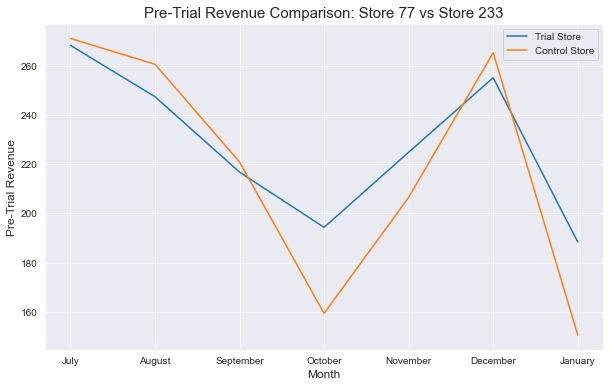

In [24]:
plot_comparison(store_77_pre_trial, store_233_pre_trial, 'TOT_SALES', 'Pre-Trial Revenue', 77, 233)

We see that the performance of store 233 closely resembles the trends for store 77 prior to the trial in terms of total sales. 
Let's have a look at number of customers and product quantities.

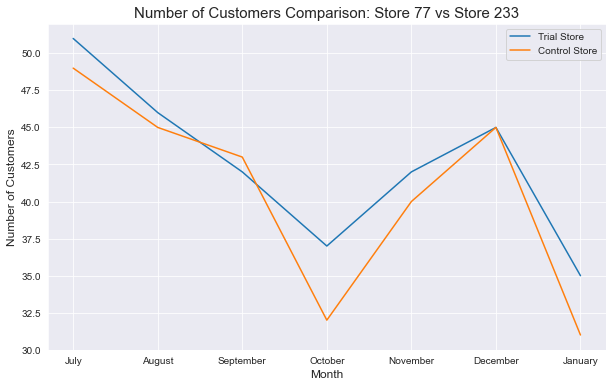

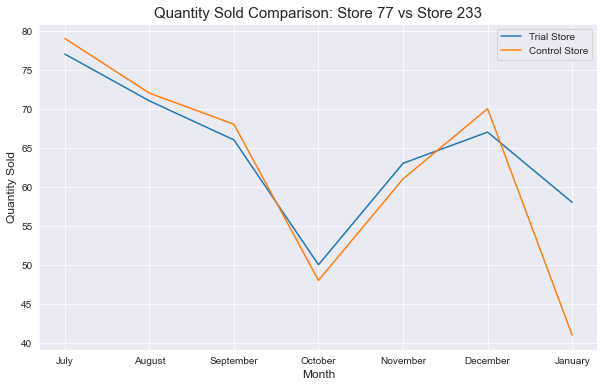

In [25]:
plot_comparison(store_77_pre_trial, store_233_pre_trial, 'customers', 'Number of Customers', 77, 233)
plot_comparison(store_77_pre_trial, store_233_pre_trial, 'PROD_QTY', 'Quantity Sold', 77, 233)


Again we see a closely resemblence of performance for both number of customers and quantity sold.

# 2 (a)(ii) Assessment of Trial - Store 77

Now that we have our control store, let's reprepare out data so it's easier to analyze. We will only have to do this once since the resulting df can be used for the other trial stores.

In [31]:
# Re-prepare data for analysis

# Create copy of original df
analysis_df = data

# Format date columns
analysis_df['real_date'] = pd.to_datetime(analysis_df['real_date'], format = "%Y-%m-%d")

# Add new month ID column with easier to read format
analysis_df['MONTH_ID'] = analysis_df['real_date'].dt.strftime("%Y%m").astype('int')
analysis_df.MONTH_ID.head()

0    201807
1    201807
2    201807
3    201807
4    201807
Name: MONTH_ID, dtype: int32

Now we should create our measures to use during the analysis.

In [32]:
# Monthly sales
mSales = analysis_df.groupby(['STORE_NBR', 'MONTH_ID'])['TOT_SALES'].sum()

# Monthly number of customers
mCustomers = analysis_df.groupby(['STORE_NBR', 'MONTH_ID'])['LYLTY_CARD_NBR'].nunique()

# Average Unit Price
mAvgUnitPrice = mSales / analysis_df.groupby(['STORE_NBR','MONTH_ID'])['PROD_QTY'].sum()

# Merge together
measuresOverTime = pd.concat([mSales, mCustomers, mAvgUnitPrice], axis = 1)
measuresOverTime.columns = ['totSales', 'nCustomers', 'avgUnitPrice']
measuresOverTime = measuresOverTime.reset_index()
measuresOverTime

,STORE_NBR,MONTH_ID,totSales,nCustomers,avgUnitPrice
0,1,201807,188.9,47,3.256897
1,1,201808,168.4,41,3.238462
2,1,201809,268.1,57,3.776056
3,1,201810,175.4,39,3.439216
4,1,201811,184.8,44,3.360000
...,...,...,...,...,...
3160,272,201902,385.3,44,4.329213
3161,272,201903,421.9,48,4.349485
3162,272,201904,445.1,54,4.239048
3163,272,201905,314.6,34,4.430986


Our next step is to group into observation periods of pre-trial and full periods (whole FY).

In [35]:
# Filter stores with full obs periods
obs_full = measuresOverTime['STORE_NBR'].value_counts()
active_idx = obs_full[obs_full == 12].index
fullActiveStores = measuresOverTime[measuresOverTime['STORE_NBR'].isin(active_idx)]

# Grab pre_trial_measures
preTrialMeasures = fullActiveStores[fullActiveStores['MONTH_ID'] < 201902]
preTrialMeasures.head(10)

,STORE_NBR,MONTH_ID,totSales,nCustomers,avgUnitPrice
0,1,201807,188.9,47,3.256897
1,1,201808,168.4,41,3.238462
2,1,201809,268.1,57,3.776056
3,1,201810,175.4,39,3.439216
4,1,201811,184.8,44,3.360000
5,1,201812,160.6,37,3.345833
6,1,201901,149.7,35,3.651220
12,2,201807,140.5,36,3.267442
13,2,201808,180.9,35,3.618000
14,2,201809,133.9,32,3.719444


The trial period goes from the start of Febuary 2019 through April 2019. We now want to see if there has been an uplift in overall chip sales. 
We'll start with scaling the control store's sales to a similar level to control for any differences between the two stores outside of the trial period.

In [37]:
# Scale pre-trial control sales to match pre-trial stores sales
scalingFactorControlSales77 = (measuresOverTime[measuresOverTime['STORE_NBR'] == 77]['totSales'].sum()) / (measuresOverTime[measuresOverTime['STORE_NBR'] == 233]['totSales'].sum())
print(f'Scaling Factor store 77: {scalingFactorControlSales77}')

Scaling Factor store 77: 1.0965972731837317


In [39]:
# apply scaling factor
scaledControlSales233 = measuresOverTime[measuresOverTime['STORE_NBR'] == 233]
scaledControlSales233['controlSales'] = scaledControlSales233['totSales'] * scalingFactorControlSales77
scaledControlSales233

,STORE_NBR,MONTH_ID,totSales,nCustomers,avgUnitPrice,controlSales
2695,233,201807,271.2,47,3.432911,297.397180
2696,233,201808,260.7,44,3.620833,285.882909
2697,233,201809,220.9,40,3.248529,242.238338
2698,233,201810,159.3,32,3.318750,174.687946
2699,233,201811,206.5,39,3.385246,226.447337
2700,233,201812,265.4,43,3.791429,291.036916
2701,233,201901,150.5,31,3.670732,165.037890
2702,233,201902,220.7,42,3.448438,242.019018
2703,233,201903,180.6,35,3.473077,198.045468
2704,233,201904,144.2,27,3.517073,158.129327


Now that we have comparable sales figures, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.

In [46]:
# Get percentage difference between scaled control sales and trial sales
trialSales77 = measuresOverTime[measuresOverTime['STORE_NBR'] == 77].reset_index(drop = True)
scaledControlSales233 = scaledControlSales233.reset_index(drop = True)
percentageDiffSales77 = pd.concat([trialSales77['MONTH_ID'], trialSales77['totSales'], scaledControlSales233['controlSales']], axis = 1)
percentageDiffSales77.columns = ['MONTH_ID', 'trialSales', 'controlSales']
percentageDiffSales77['PercentageDiff'] = (abs(percentageDiffSales77['trialSales'] - percentageDiffSales77['controlSales']))/percentageDiffSales77['controlSales']
months = ["July '18", "Aug '18","Sept '18","Oct '18","Nov '18","Dec '18","Jan '19","Feb '19","Mar '19","Apr '19","May '19","June '19" ]
percentageDiffSales77['MonthYear'] = months
percentageDiffSales77

,MONTH_ID,trialSales,controlSales,PercentageDiff,MonthYear
0,201807,268.4,297.397180,0.097503,July '18
1,201808,247.5,285.882909,0.134261,Aug '18
2,201809,216.8,242.238338,0.105014,Sept '18
3,201810,194.3,174.687946,0.112269,Oct '18
4,201811,224.9,226.447337,0.006833,Nov '18
5,201812,255.2,291.036916,0.123135,Dec '18
6,201901,188.4,165.037890,0.141556,Jan '19
7,201902,211.6,242.019018,0.125689,Feb '19
8,201903,255.1,198.045468,0.288088,Mar '19
9,201904,258.1,158.129327,0.632208,Apr '19


In [169]:
def plot_statistics(df, trial_metric, control_metric, title_metric, trial_store_number, control_store_number):
    plt.figure(figsize = (10,6))
    sns.set_style('darkgrid')
    sns.lineplot(data = df, x = df['MonthYear'], y = trial_metric, legend = 'auto')
    sns.lineplot(data = df, x = df['MonthYear'], y = control_metric, legend = 'auto')
    plt.title(f'{title_metric} Comparison: Store {trial_store_number} vs Store {control_store_number}', fontsize = 15)
    labels = ['Trial Store', 'Control Store']
    plt.xlabel('Month', fontsize = 12)
    plt.ylabel(title_metric, fontsize = 12)
    plt.legend(labels, loc = 'best')
    plt.axvline(7, linestyle = '--', color = 'g', linewidth = 1.1)
    plt.axvline(9, linestyle = '--', color = 'g', linewidth = 1.1)
    limit = df[control_metric].max()
    plt.text(5.8, 0.92 * limit, 'Begin Trial')
    plt.text(9.1, 0.95 * limit, 'End Trial')
    plt.show()

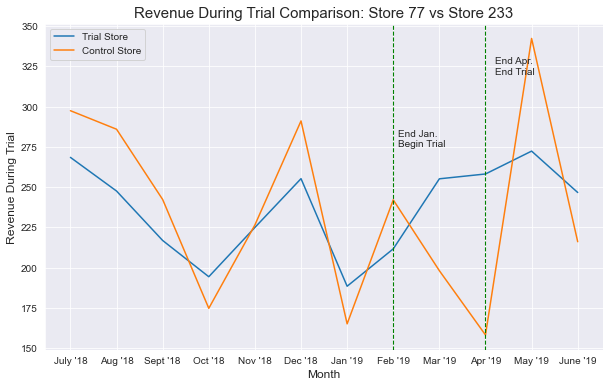

In [76]:
plot_statistics(percentageDiffSales77, 'trialSales', 'controlSales', 'Revenue During Trial', 77, 233)

# 2 (a)(iii) Insights - Store 77 Sales
-------------------------------------------
SALES:
- Store 77 had a dramatic increase of sales over its control store in 2/3 months.
- In month 1 of the trial, the control store was ahead of store 77 by 12.6%.
- However, for month 2 and 3 (Mar & Apr), sales appeared to have higher by 28.9% & 63.2% respectively. 
- We can see that once the trial begins, the control store increases, but sharply decreases towards march through to April.



# 2 (a)(iv) Significance Testing Store 77 - Sales
Let's see if the difference in the distributions are significant.
We can do this using a t-test.
Our first null hypothesis is that the trial period is the same as the pre-trial period. Let's take the standrd deviation based on the scaled percentage difference in the pre-trial period. 

We will test with a null hypothesis of there being 0 difference between trial and control stores.

In [79]:
# degrees of freedom
"""
Since there are 8 months in the pre-trial period, dof = 7.
"""
dof = 7

# Standard deviation of percentage difference in pre-trial period
stdv77s = percentageDiffSales77[percentageDiffSales77['MONTH_ID'] < 201902]['PercentageDiff'].std()
print(f'Standard Deviation: {stdv77}')

Standard Deviation: 0.045161704066012505


In [80]:
# Calculate T values for trial months.
percentageDiffSales77['tValue'] = (percentageDiffSales77['PercentageDiff'] - 0) / stdv77s
percentageDiffSales77

,MONTH_ID,trialSales,controlSales,PercentageDiff,MonthYear,tValue
0,201807,268.4,297.397180,0.097503,July '18,2.158980
1,201808,247.5,285.882909,0.134261,Aug '18,2.972894
2,201809,216.8,242.238338,0.105014,Sept '18,2.325281
3,201810,194.3,174.687946,0.112269,Oct '18,2.485935
4,201811,224.9,226.447337,0.006833,Nov '18,0.151303
5,201812,255.2,291.036916,0.123135,Dec '18,2.726542
6,201901,188.4,165.037890,0.141556,Jan '19,3.134426
7,201902,211.6,242.019018,0.125689,Feb '19,2.783078
8,201903,255.1,198.045468,0.288088,Mar '19,6.379034
9,201904,258.1,158.129327,0.632208,Apr '19,13.998770


In [92]:
# lineplot the confidence intervals df
ciSales77 = percentageDiffSales77[['MONTH_ID', 'MonthYear', 'trialSales','controlSales', 'tValue']]
ciSales77['95th%ConfidenceInterv'] = ciSales77['controlSales'] * (1+(stdv77s * 2))
ciSales77['5th%ConfidenceInterv'] = ciSales77['controlSales']* (1-(stdv77s * 2))
ciSales77

,MONTH_ID,MonthYear,trialSales,controlSales,tValue,95th%ConfidenceInterv,5th%ConfidenceInterv
0,201807,July '18,268.4,297.397180,2.158980,324.259107,270.535254
1,201808,Aug '18,247.5,285.882909,2.972894,311.704828,260.060990
2,201809,Sept '18,216.8,242.238338,2.325281,264.118130,220.358545
3,201810,Oct '18,194.3,174.687946,2.485935,190.466356,158.909535
4,201811,Nov '18,224.9,226.447337,0.151303,246.900832,205.993842
5,201812,Dec '18,255.2,291.036916,2.726542,317.324362,264.749470
6,201901,Jan '19,188.4,165.037890,3.134426,179.944674,150.131105
7,201902,Feb '19,211.6,242.019018,2.783078,263.879001,220.159036
8,201903,Mar '19,255.1,198.045468,6.379034,215.933609,180.157326
9,201904,Apr '19,258.1,158.129327,13.998770,172.412107,143.846547


In [189]:
# Plotting function for CI
def plot_confidence_interval(df, measure, trial_metric, control_metric, nthCi, fthCi, trial_store, control_store):
    plt.figure(figsize = (10,6))
    sns.set_style('darkgrid')
    sns.lineplot(data = df, x = df['MonthYear'], y = trial_metric, color = 'magenta', alpha = 0.6)
    sns.lineplot(data = df, x = df['MonthYear'], y = control_metric, color = 'cyan', alpha = 0.6)
    sns.lineplot(data = df, x = df['MonthYear'], y = nthCi, color = 'red', alpha = 0.4)
    sns.lineplot(data = df, x = df['MonthYear'], y = fthCi, color = 'blue', alpha = 0.4)
    plt.axvline(7, linestyle = '--', color = 'g', linewidth = 1.1)
    plt.title(f'{measure} by Month (Trial Store {trial_store} vs Control Store {control_store})', fontsize = 15)
    labels = ['Trial Store', 'Control Store', 'Control 95th % Confidence Interval', 'Control 5th % Confidence Interval']
    plt.xlabel('Month', fontsize = 12)
    plt.ylabel(measure, fontsize = 12)
    plt.legend(labels, loc = 'best')
    
    plt.axvline(9, linestyle = '--', color = 'g', linewidth = 1.1)
    limit = df[nthCi].max()
    plt.text(5.8, 0.92 * limit, 'Begin Trial')
    plt.text(9.1, 0.95 * limit, 'End Trial')

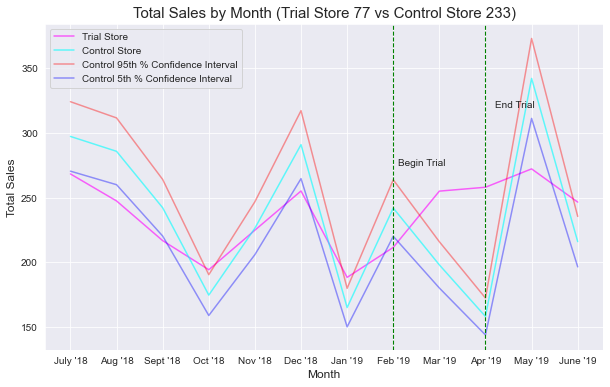

In [120]:
plot_confidence_interval(ciSales77, 'Total Sales', 'trialSales', 'controlSales', '95th%ConfidenceInterv', '5th%ConfidenceInterv')

In [81]:
# Find the t-value range corresponding to a 95% confidence interval
stats.t.ppf(0.975, # quantile to check
           dof)    # Degrees of Freedom (number of samples - 1)

2.3646242510102993

Our results show that the t-values for all 3 months of the trial lay outside the 5% to 95% confidence intervalue value of the t-distribution. This tells us that the changes in sales for store 77 are statistically significant.

We can now do the same with customers.

# 2 (a)(v) Analysis: Store 77 Customers

In [124]:
# Scale pre-trial control customers to match pre-trial trial store customers
scalingFactorControlCust77 = (measuresOverTime[measuresOverTime['STORE_NBR'] == 77]['nCustomers'].sum())/ (measuresOverTime[measuresOverTime['STORE_NBR'] == 233]['nCustomers'].sum())
print(f'Scaling Factor (cust) for store 77: {scalingFactorControlCust77}')

Scaling Factor (cust) for store 77: 1.0811965811965811


In [126]:
# Apply Scaling Factor
scaledControlCust233 = measuresOverTime[measuresOverTime['STORE_NBR'] == 233]
scaledControlCust233['controlCust'] = scaledControlCust233['nCustomers'] * scalingFactorControlCust77
scaledControlCust233

,STORE_NBR,MONTH_ID,totSales,nCustomers,avgUnitPrice,controlCust
2695,233,201807,271.2,47,3.432911,50.816239
2696,233,201808,260.7,44,3.620833,47.572650
2697,233,201809,220.9,40,3.248529,43.247863
2698,233,201810,159.3,32,3.318750,34.598291
2699,233,201811,206.5,39,3.385246,42.166667
2700,233,201812,265.4,43,3.791429,46.491453
2701,233,201901,150.5,31,3.670732,33.517094
2702,233,201902,220.7,42,3.448438,45.410256
2703,233,201903,180.6,35,3.473077,37.841880
2704,233,201904,144.2,27,3.517073,29.192308


Now that we have comaprable customer figures, we can calculate the percentage difference between the scaled control customers and the trial store's customers during the trial period.

In [128]:
# Get percentage difference between scaled control customers and trial customers
trialCust77 = measuresOverTime[measuresOverTime['STORE_NBR'] == 77].reset_index(drop = True)
scaledControlCust233 = scaledControlCust233.reset_index(drop = True)
percentageDiffCust77 = pd.concat([trialCust77['MONTH_ID'], trialCust77['nCustomers'], scaledControlCust233['controlCust']], axis = 1)
percentageDiffCust77.columns = ['MONTH_ID', 'trialCust', 'controlCust']
percentageDiffCust77['PercentageDiff'] = (abs(percentageDiffCust77['trialCust'] - percentageDiffCust77['controlCust'])) / percentageDiffCust77['controlCust']
percentageDiffCust77['MonthYear'] = months
percentageDiffCust77

,MONTH_ID,trialCust,controlCust,PercentageDiff,MonthYear
0,201807,47,50.816239,0.075099,July '18
1,201808,46,47.572650,0.033058,Aug '18
2,201809,40,43.247863,0.075099,Sept '18
3,201810,36,34.598291,0.040514,Oct '18
4,201811,39,42.166667,0.075099,Nov '18
5,201812,43,46.491453,0.075099,Dec '18
6,201901,31,33.517094,0.075099,Jan '19
7,201902,40,45.410256,0.119142,Feb '19
8,201903,46,37.841880,0.215584,Mar '19
9,201904,47,29.192308,0.610013,Apr '19


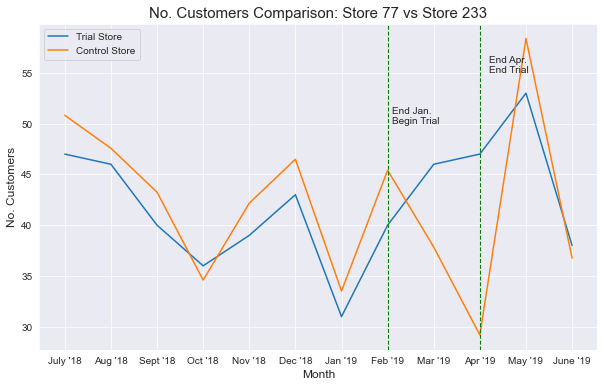

In [132]:
# Plot visual of performance
plot_statistics(percentageDiffCust77, 'trialCust', 'controlCust', 'No. Customers', 77, 233)

# 2(a)(vi) Insights - Store 77 Customers

- Store 77 began the trial with a smaller amount of customers than the control store.
- In March and April, the number of customers far outgrew the amount of the control store in those months.
- In Febuary, the control store 233 had 12% more customers.
- In the following months, store 77 had 21.5% & 61% more customers than the control store.

# 2(a)(vii) Significance Testing - Customers

Let's see if the difference in the distributions are significant. We can do this using a t-test. Our first null hypothesis is that the trial period is the same as the pre-trial period. Let's take the standard deviation based on the scaled percentage difference in the pre-trial period.

We will test with a null hypothesis of there being 0 difference between the trial and control stores.

In [133]:
# degrees of freedom
"""
Since there are 8 months in the pre-trial period, dof = 7.
"""
dof = 7

# Standard deviation of percentage difference in pre-trial period
stdv77c = percentageDiffCust77[percentageDiffCust77['MONTH_ID'] < 201902]['PercentageDiff'].std()
print(f'Standard Deviation: {stdv77c}')

Standard Deviation: 0.018818309735266672


In [134]:
# Calculate T values for trial months.
percentageDiffCust77['tValue'] = (percentageDiffCust77['PercentageDiff'] - 0) / stdv77c
percentageDiffCust77

,MONTH_ID,trialCust,controlCust,PercentageDiff,MonthYear,tValue
0,201807,47,50.816239,0.075099,July '18,3.990731
1,201808,46,47.572650,0.033058,Aug '18,1.756685
2,201809,40,43.247863,0.075099,Sept '18,3.990731
3,201810,36,34.598291,0.040514,Oct '18,2.152894
4,201811,39,42.166667,0.075099,Nov '18,3.990731
5,201812,43,46.491453,0.075099,Dec '18,3.990731
6,201901,31,33.517094,0.075099,Jan '19,3.990731
7,201902,40,45.410256,0.119142,Feb '19,6.331160
8,201903,46,37.841880,0.215584,Mar '19,11.456099
9,201904,47,29.192308,0.610013,Apr '19,32.415939


Our t-value will tell allow us to test with a null hypothesis that there is zero difference between trial and control stores.

In [135]:
ciCust77 = percentageDiffCust77[['MONTH_ID', 'MonthYear', 'trialCust','controlCust', 'tValue']]
ciCust77['95th%ConfidenceInterv'] = ciCust77['controlCust'] * (1+(stdv77c * 2))
ciCust77['5th%ConfidenceInterv'] = ciCust77['controlCust']* (1-(stdv77c * 2))
ciCust77

,MONTH_ID,MonthYear,trialCust,controlCust,tValue,95th%ConfidenceInterv,5th%ConfidenceInterv
0,201807,July '18,47,50.816239,3.990731,52.728791,48.903688
1,201808,Aug '18,46,47.572650,1.756685,49.363123,45.782176
2,201809,Sept '18,40,43.247863,3.990731,44.875567,41.620160
3,201810,Oct '18,36,34.598291,2.152894,35.900453,33.296128
4,201811,Nov '18,39,42.166667,3.990731,43.753677,40.579656
5,201812,Dec '18,43,46.491453,3.990731,48.241234,44.741672
6,201901,Jan '19,31,33.517094,3.990731,34.778564,32.255624
7,201902,Feb '19,40,45.410256,6.331160,47.119345,43.701168
8,201903,Mar '19,46,37.841880,11.456099,39.266121,36.417640
9,201904,Apr '19,47,29.192308,32.415939,30.291007,28.093608


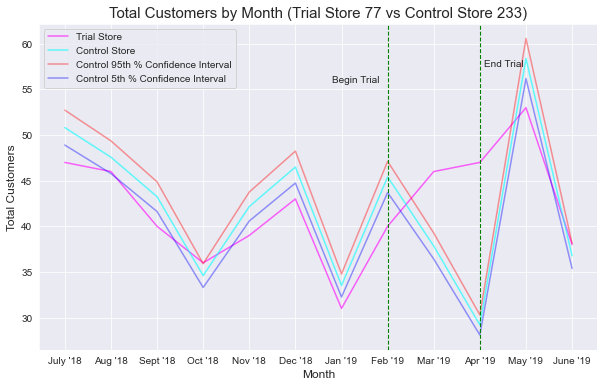

In [190]:
# Plot confidence intervals
plot_confidence_interval(ciCust77, 'Total Customers', 'trialCust', 'controlCust', '95th%ConfidenceInterv', '5th%ConfidenceInterv', 77, 233)

In [139]:
# Find the t-value range corresponding to a 95% confidence interval
stats.t.ppf(0.975, # quantile to check
           dof)    # Degrees of Freedom (number of samples - 1)

2.3646242510102993

Our results show that the t-values for all 3 months of the trial lay outside the 5% to 95% confidence interval value of the t-distribution. This tells us that the changes in customers for store 77 are statistically significant.

# 2(b)(i) - Analysis - Store 86

Let's find a control store for store 77.

In [141]:
find_control_store(0, 86)

Store with closest euclidean distance to trial store 86: Store 155 
----------------------------------------


Now that we have a control store, let's check visually if the drivers are indeed similar in the period before the trial. We can check total sales first.

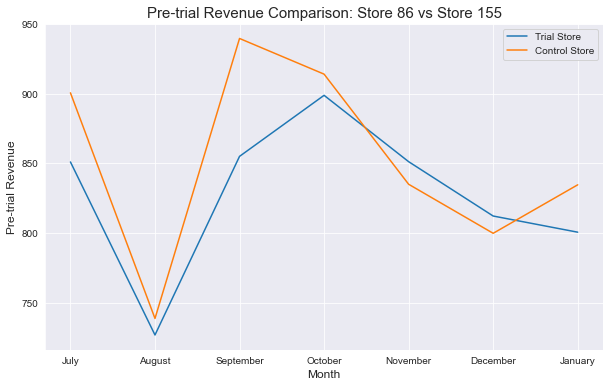

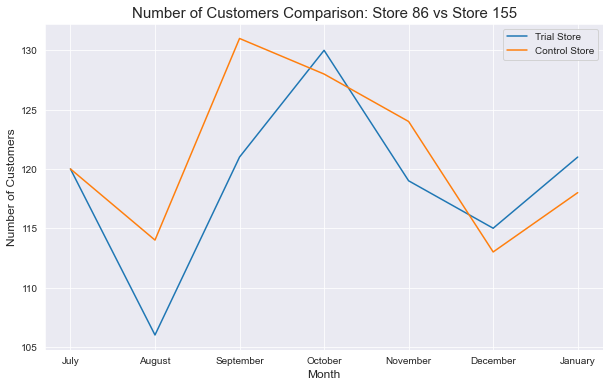

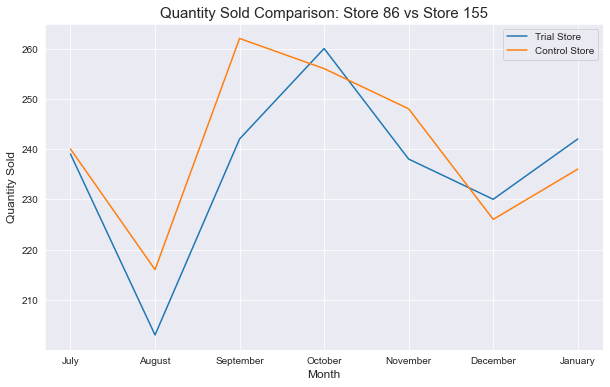

In [144]:
store_86_pre_trial = pre_trial_analysis(trial_rec, 86)
store_155_pre_trial = pre_trial_analysis(control_rec, 155)
plot_comparison(store_86_pre_trial, store_155_pre_trial, 'TOT_SALES', 'Pre-trial Revenue', 86, 155)
plot_comparison(store_86_pre_trial, store_155_pre_trial, 'customers', 'Number of Customers', 86, 155)
plot_comparison(store_86_pre_trial, store_155_pre_trial, 'PROD_QTY', 'Quantity Sold', 86, 155)

We can see that the performance of store 155 closely resembles the trends for store 86 prior to the trial in terms of sales, customers and product quantity sold. 

# 2(b)(ii) Assessment of Trial - Store 86

Now that we have our control store, we can begin to analyze the data. The trial period goes from the start of Feb 2019 through to Apr 2019. We now want to see if there has been an uplift in overall chip sales. We can start with scaling the control store's sales to a similar level to control for any differences between the two stores outside the trial period.

In [146]:
# Scale pre-trial control sales to match pre-trial stores sales
scalingFactorControlSales86 = (measuresOverTime[measuresOverTime['STORE_NBR'] == 86]['totSales'].sum()) / (measuresOverTime[measuresOverTime['STORE_NBR'] == 155]['totSales'].sum())
print(f'Scaling Factor store 86: {scalingFactorControlSales86}')

Scaling Factor store 86: 1.0006197180282972


In [147]:
# apply scaling factor
scaledControlSales155 = measuresOverTime[measuresOverTime['STORE_NBR'] == 155]
scaledControlSales155['controlSales'] = scaledControlSales155['totSales'] * scalingFactorControlSales86
scaledControlSales155

,STORE_NBR,MONTH_ID,totSales,nCustomers,avgUnitPrice,controlSales
1792,155,201807,900.60,98,3.752500,901.158118
1793,155,201808,738.70,88,3.419907,739.157786
1794,155,201809,939.60,96,3.586260,940.182287
1795,155,201810,914.00,105,3.570313,914.566422
1796,155,201811,835.00,96,3.366935,835.517465
1797,155,201812,799.80,91,3.538938,800.295650
1798,155,201901,834.60,92,3.536441,835.117217
1799,155,201902,850.80,92,3.574790,851.327256
1800,155,201903,767.00,91,3.424107,767.475324
1801,155,201904,800.40,93,3.510526,800.896022


Now that we have comparable sales figures, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.

In [148]:
# Get percentage difference between scaled control sales and trial sales
trialSales86 = measuresOverTime[measuresOverTime['STORE_NBR'] == 86].reset_index(drop = True)
scaledControlSales155 = scaledControlSales155.reset_index(drop = True)
percentageDiffSales86 = pd.concat([trialSales86['MONTH_ID'], trialSales86['totSales'], scaledControlSales155['controlSales']], axis = 1)
percentageDiffSales86.columns = ['MONTH_ID', 'trialSales', 'controlSales']
percentageDiffSales86['PercentageDiff'] = (abs(percentageDiffSales86['trialSales'] - percentageDiffSales86['controlSales']))/percentageDiffSales86['controlSales']
percentageDiffSales86['MonthYear'] = months
percentageDiffSales86

,MONTH_ID,trialSales,controlSales,PercentageDiff,MonthYear
0,201807,851.00,901.158118,0.055660,July '18
1,201808,726.85,739.157786,0.016651,Aug '18
2,201809,855.00,940.182287,0.090602,Sept '18
3,201810,898.80,914.566422,0.017239,Oct '18
4,201811,851.20,835.517465,0.018770,Nov '18
5,201812,812.20,800.295650,0.014875,Dec '18
6,201901,800.60,835.117217,0.041332,Jan '19
7,201902,872.80,851.327256,0.025223,Feb '19
8,201903,945.40,767.475324,0.231831,Mar '19
9,201904,804.00,800.896022,0.003876,Apr '19


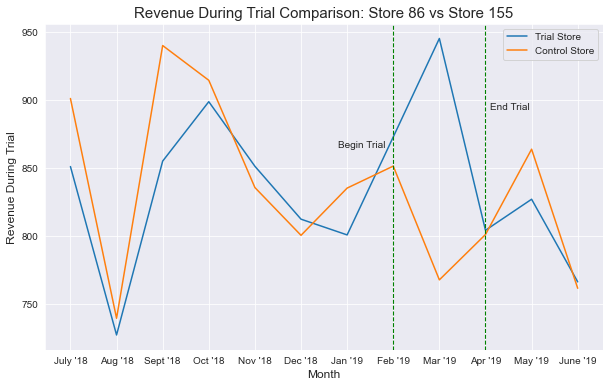

In [170]:
plot_statistics(percentageDiffSales86, 'trialSales', 'controlSales', 'Revenue During Trial', 86, 155)

# 2(b)(iii) Insights - Store 86 Sales

- Store 86 had an increase in sales over its control store in 2/3 months.
- In Febuary and March, store 86 had 2.5% then a dramatic increase to 23% higher sales respectively over control store 155.
- However, in April, the trial store sales dropped back to match the control store.

# 2(b)(iv) Significance Testing Store 86 - Sales

Let's see if the difference in the distributions are significant.
We can do this using a t-test.
Our first null hypothesis is that the trial period is the same as the pre-trial period. Let's take the standrd deviation based on the scaled percentage difference in the pre-trial period. 

We will test with a null hypothesis of there being 0 difference between trial and control stores.

In [171]:
# degrees of freedom
"""
Since there are 8 months in the pre-trial period, dof = 7.
"""
dof = 7

# Standard deviation of percentage difference in pre-trial period
stdv86s = percentageDiffSales86[percentageDiffSales86['MONTH_ID'] < 201902]['PercentageDiff'].std()
print(f'Standard Deviation: {stdv86s}')

Standard Deviation: 0.028473359044104682


In [172]:
# Calculate T values for trial months.
percentageDiffSales86['tValue'] = (percentageDiffSales86['PercentageDiff'] - 0) / stdv86s
percentageDiffSales86

,MONTH_ID,trialSales,controlSales,PercentageDiff,MonthYear,tValue
0,201807,851.00,901.158118,0.055660,July '18,1.954796
1,201808,726.85,739.157786,0.016651,Aug '18,0.584796
2,201809,855.00,940.182287,0.090602,Sept '18,3.181988
3,201810,898.80,914.566422,0.017239,Oct '18,0.605451
4,201811,851.20,835.517465,0.018770,Nov '18,0.659207
5,201812,812.20,800.295650,0.014875,Dec '18,0.522416
6,201901,800.60,835.117217,0.041332,Jan '19,1.451609
7,201902,872.80,851.327256,0.025223,Feb '19,0.885834
8,201903,945.40,767.475324,0.231831,Mar '19,8.142037
9,201904,804.00,800.896022,0.003876,Apr '19,0.136114


In [173]:
# lineplot the confidence intervals df
ciSales86 = percentageDiffSales86[['MONTH_ID', 'MonthYear', 'trialSales','controlSales', 'tValue']]
ciSales86['95th%ConfidenceInterv'] = ciSales86['controlSales'] * (1+(stdv86s * 2))
ciSales86['5th%ConfidenceInterv'] = ciSales86['controlSales']* (1-(stdv86s * 2))
ciSales86

,MONTH_ID,MonthYear,trialSales,controlSales,tValue,95th%ConfidenceInterv,5th%ConfidenceInterv
0,201807,July '18,851.00,901.158118,1.954796,952.476115,849.840121
1,201808,Aug '18,726.85,739.157786,0.584796,781.250396,697.065176
2,201809,Sept '18,855.00,940.182287,3.181988,993.722583,886.641991
3,201810,Oct '18,898.80,914.566422,0.605451,966.647979,862.484866
4,201811,Nov '18,851.20,835.517465,0.659207,883.097442,787.937487
5,201812,Dec '18,812.20,800.295650,0.522416,845.869861,754.721440
6,201901,Jan '19,800.60,835.117217,1.451609,882.674401,787.560032
7,201902,Feb '19,872.80,851.327256,0.885834,899.807549,802.846963
8,201903,Mar '19,945.40,767.475324,8.142037,811.180525,723.770123
9,201904,Apr '19,804.00,800.896022,0.136114,846.504422,755.287622


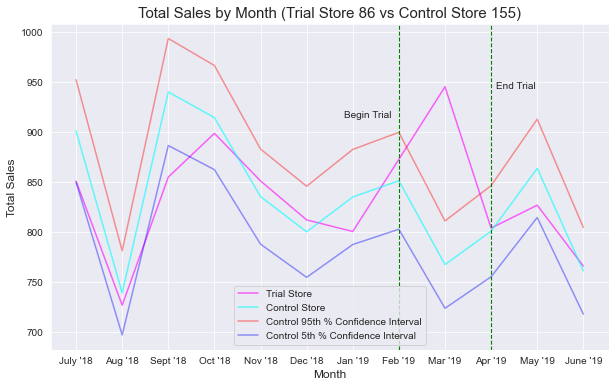

In [178]:
# Plot confidence intervals
plot_confidence_interval(ciSales86, 'Total Sales', 'trialSales', 'controlSales', '95th%ConfidenceInterv', '5th%ConfidenceInterv', 86, 155)

In [179]:
# Find the t-value range corresponding to a 95% confidence interval
stats.t.ppf(0.975, # quantile to check
           dof)    # Degrees of Freedom (number of samples - 1)

2.3646242510102993

Our results show that only the month of March lay outside the 5th % and 95th% confidence interval range of the t-distribution. This tells us that only sales in March are statistically greater than the control store.

We will now do the same with customers.

# 2(b)(v) Analysis: Store 86 Customers

In [180]:
# Scale pre-trial control customers to match pre-trial trial store customers
scalingFactorControlCust86 = (measuresOverTime[measuresOverTime['STORE_NBR'] == 86]['nCustomers'].sum())/ (measuresOverTime[measuresOverTime['STORE_NBR'] == 155]['nCustomers'].sum())
print(f'Scaling Factor (cust) for store 86: {scalingFactorControlCust86}')

Scaling Factor (cust) for store 86: 1.036283185840708


In [181]:
# Apply Scaling Factor
scaledControlCust155 = measuresOverTime[measuresOverTime['STORE_NBR'] == 155]
scaledControlCust155['controlCust'] = scaledControlCust155['nCustomers'] * scalingFactorControlCust86
scaledControlCust155

,STORE_NBR,MONTH_ID,totSales,nCustomers,avgUnitPrice,controlCust
1792,155,201807,900.60,98,3.752500,101.555752
1793,155,201808,738.70,88,3.419907,91.192920
1794,155,201809,939.60,96,3.586260,99.483186
1795,155,201810,914.00,105,3.570313,108.809735
1796,155,201811,835.00,96,3.366935,99.483186
1797,155,201812,799.80,91,3.538938,94.301770
1798,155,201901,834.60,92,3.536441,95.338053
1799,155,201902,850.80,92,3.574790,95.338053
1800,155,201903,767.00,91,3.424107,94.301770
1801,155,201904,800.40,93,3.510526,96.374336


Now that we have comaprable customer figures, we can calculate the percentage difference between the scaled control customers and the trial store's customers during the trial period.

In [182]:
# Get percentage difference between scaled control customers and trial customers
trialCust86 = measuresOverTime[measuresOverTime['STORE_NBR'] == 86].reset_index(drop = True)
scaledControlCust155 = scaledControlCust155.reset_index(drop = True)
percentageDiffCust86 = pd.concat([trialCust86['MONTH_ID'], trialCust86['nCustomers'], scaledControlCust155['controlCust']], axis = 1)
percentageDiffCust86.columns = ['MONTH_ID', 'trialCust', 'controlCust']
percentageDiffCust86['PercentageDiff'] = (abs(percentageDiffCust86['trialCust'] - percentageDiffCust86['controlCust'])) / percentageDiffCust86['controlCust']
percentageDiffCust86['MonthYear'] = months
percentageDiffCust86

,MONTH_ID,trialCust,controlCust,PercentageDiff,MonthYear
0,201807,94,101.555752,0.074400,July '18
1,201808,92,91.192920,0.008850,Aug '18
2,201809,100,99.483186,0.005195,Sept '18
3,201810,105,108.809735,0.035013,Oct '18
4,201811,95,99.483186,0.045065,Nov '18
5,201812,93,94.301770,0.013804,Dec '18
6,201901,89,95.338053,0.066480,Jan '19
7,201902,105,95.338053,0.101344,Feb '19
8,201903,108,94.301770,0.145260,Mar '19
9,201904,99,96.374336,0.027244,Apr '19


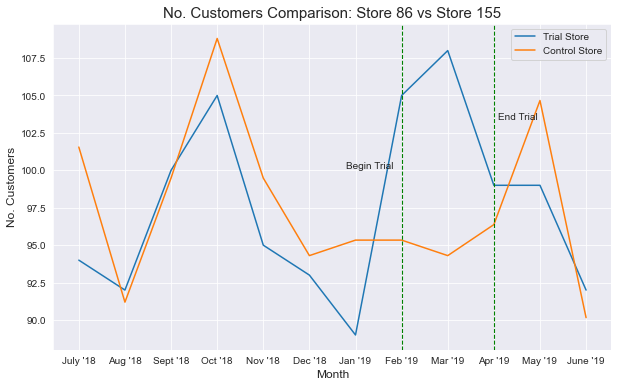

In [183]:
# Plot visual of performance
plot_statistics(percentageDiffCust86, 'trialCust', 'controlCust', 'No. Customers', 86, 155)

# 2(b)(vi) Insights - Store 86 Customers

- Store 86 had a dramatic increase in customers over the first half of the trial period compared to its control store.
- Throughout the trial period, it had 10.1%, 14.5% and 2.7% subsequent higher numbers of customers over store 115. 
- Coupled with the sales data, this appears to not match.
- It may suggest a possibility that there were discount specials present in the months which did not achieve higher than the control store, since there was indeed more customers but not moresales.

# 2(b)(vii) Significance Testing - Customers

Let's see if the difference in the distributions are significant. We can do this using a t-test. Our first null hypothesis is that the trial period is the same as the pre-trial period. Let's take the standrd deviation based on the scaled percentage difference in the pre-trial period.

We will test with a null hypothesis of there being 0 difference between trial and control stores.

In [184]:
# degrees of freedom
"""
Since there are 8 months in the pre-trial period, dof = 7.
"""
dof = 7

# Standard deviation of percentage difference in pre-trial period
stdv86c = percentageDiffCust86[percentageDiffCust86['MONTH_ID'] < 201902]['PercentageDiff'].std()
print(f'Standard Deviation: {stdv86c}')

Standard Deviation: 0.02788062420844365


In [185]:
# Calculate T values for trial months.
percentageDiffCust86['tValue'] = (percentageDiffCust86['PercentageDiff'] - 0) / stdv86c
percentageDiffCust86

,MONTH_ID,trialCust,controlCust,PercentageDiff,MonthYear,tValue
0,201807,94,101.555752,0.074400,July '18,2.668521
1,201808,92,91.192920,0.008850,Aug '18,0.317434
2,201809,100,99.483186,0.005195,Sept '18,0.186330
3,201810,105,108.809735,0.035013,Oct '18,1.255812
4,201811,95,99.483186,0.045065,Nov '18,1.616347
5,201812,93,94.301770,0.013804,Dec '18,0.495122
6,201901,89,95.338053,0.066480,Jan '19,2.384444
7,201902,105,95.338053,0.101344,Feb '19,3.634929
8,201903,108,94.301770,0.145260,Mar '19,5.210053
9,201904,99,96.374336,0.027244,Apr '19,0.977181


Our t-value will tell allow us to test with a null hypothesis that there is zero difference between trial and control stores.

In [187]:
ciCust86 = percentageDiffCust86[['MONTH_ID', 'MonthYear', 'trialCust','controlCust', 'tValue']]
ciCust86['95th%ConfidenceInterv'] = ciCust86['controlCust'] * (1+(stdv86c * 2))
ciCust86['5th%ConfidenceInterv'] = ciCust86['controlCust']* (1-(stdv86c * 2))
ciCust86

,MONTH_ID,MonthYear,trialCust,controlCust,tValue,95th%ConfidenceInterv,5th%ConfidenceInterv
0,201807,July '18,94,101.555752,2.668521,107.218628,95.892877
1,201808,Aug '18,92,91.192920,0.317434,96.277951,86.107889
2,201809,Sept '18,100,99.483186,0.186330,105.030492,93.935879
3,201810,Oct '18,105,108.809735,1.255812,114.877101,102.742368
4,201811,Nov '18,95,99.483186,1.616347,105.030492,93.935879
5,201812,Dec '18,93,94.301770,0.495122,99.560154,89.043385
6,201901,Jan '19,89,95.338053,2.384444,100.654222,90.021884
7,201902,Feb '19,105,95.338053,3.634929,100.654222,90.021884
8,201903,Mar '19,108,94.301770,5.210053,99.560154,89.043385
9,201904,Apr '19,99,96.374336,0.977181,101.748290,91.000383


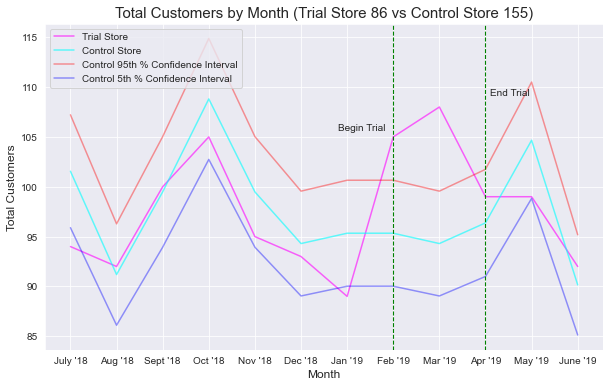

In [191]:
# Plot confidence intervals
plot_confidence_interval(ciCust86, 'Total Customers', 'trialCust', 'controlCust', '95th%ConfidenceInterv', '5th%ConfidenceInterv', 86, 155)

In [192]:
# Find the t-value range corresponding to a 95% confidence interval
stats.t.ppf(0.975, # quantile to check
           dof)    # Degrees of Freedom (number of samples - 1)

2.3646242510102993

Our results show that the t-values for Febuary and March of the trial lay outside the 5% to 95% confidence interval value of the t-distribution. This tells us that the changes in customers for store 86 are statistically significant in 2 of the 3 trial months.

# 2(c)(i) - Analysis - Store 88

Let's find a control store for store 88.

In [200]:
find_control_store(1, 88)

Store with closest euclidean distance to trial store 88: Store 237 
----------------------------------------


Now that we have a control store, let's check visually if the drivers are indeed similar in the period before the trial.

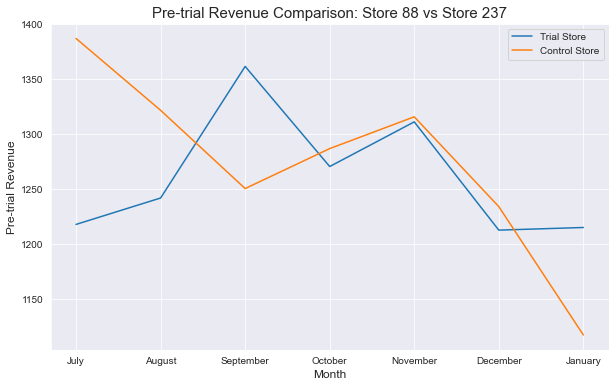

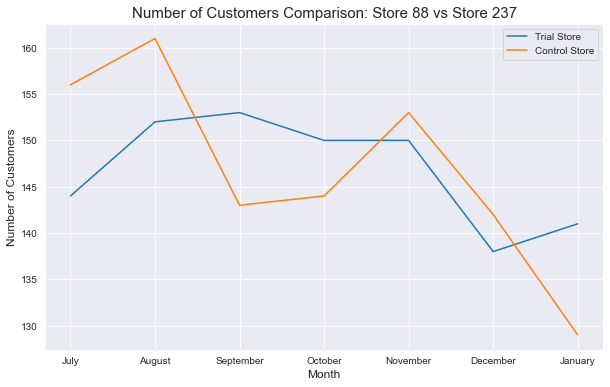

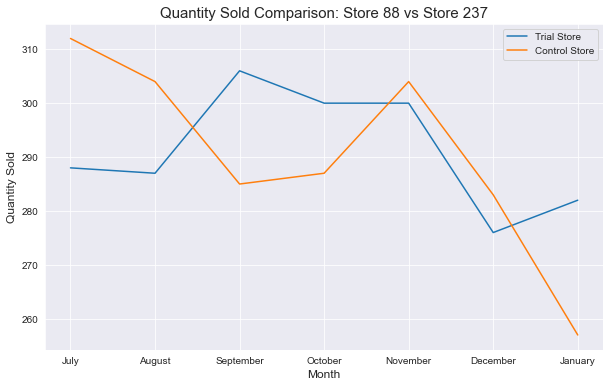

In [201]:
store_88_pre_trial = pre_trial_analysis(trial_rec, 88)
store_237_pre_trial = pre_trial_analysis(control_rec, 237)
plot_comparison(store_88_pre_trial, store_237_pre_trial, 'TOT_SALES', 'Pre-trial Revenue', 88, 237)
plot_comparison(store_88_pre_trial, store_237_pre_trial, 'customers', 'Number of Customers', 88, 237)
plot_comparison(store_88_pre_trial, store_237_pre_trial, 'PROD_QTY', 'Quantity Sold', 88, 237)

We can see that the performance of store 237 resembles the trends for store 88 prior to the trial in terms of sales, customers and product quantity sold.

# 2(c)(ii) Assessment of Trial - Store 88

Now that we have our control store, we can begin to analyze the data. The trial period goes from the start of Feb 2019 through to Apr 2019. We now want to see if there has been an uplift in overall chip sales. We can start with scaling the control store's sales to a similar level to control for any differences between the two stores outside the trial period.

In [202]:
# Scale pre-trial control sales to match pre-trial stores sales
scalingFactorControlSales88 = (measuresOverTime[measuresOverTime['STORE_NBR'] == 88]['totSales'].sum()) / (measuresOverTime[measuresOverTime['STORE_NBR'] == 237]['totSales'].sum())
print(f'Scaling Factor store 88: {scalingFactorControlSales88}')

Scaling Factor store 88: 1.0414851725486496


In [204]:
# apply scaling factor
scaledControlSales237 = measuresOverTime[measuresOverTime['STORE_NBR'] == 237]
scaledControlSales237['controlSales'] = scaledControlSales237['totSales'] * scalingFactorControlSales88
scaledControlSales237

,STORE_NBR,MONTH_ID,totSales,nCustomers,avgUnitPrice,controlSales
2743,237,201807,1387.2,125,4.446154,1444.748231
2744,237,201808,1321.9,132,4.348355,1376.739250
2745,237,201809,1250.8,120,4.388772,1302.689654
2746,237,201810,1287.1,118,4.484669,1340.495566
2747,237,201811,1316.0,125,4.328947,1370.594487
2748,237,201812,1234.4,121,4.361837,1285.609297
2749,237,201901,1117.7,111,4.349027,1164.067977
2750,237,201902,1313.0,119,4.435811,1367.470032
2751,237,201903,1177.6,116,4.394030,1226.452939
2752,237,201904,1153.6,116,4.403053,1201.457295


Now that we have comparable sales figures, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.

In [205]:
# Get percentage difference between scaled control sales and trial sales
trialSales88 = measuresOverTime[measuresOverTime['STORE_NBR'] == 88].reset_index(drop = True)
scaledControlSales237 = scaledControlSales237.reset_index(drop = True)
percentageDiffSales88 = pd.concat([trialSales88['MONTH_ID'], trialSales88['totSales'], scaledControlSales237['controlSales']], axis = 1)
percentageDiffSales88.columns = ['MONTH_ID', 'trialSales', 'controlSales']
percentageDiffSales88['PercentageDiff'] = (abs(percentageDiffSales88['trialSales'] - percentageDiffSales88['controlSales']))/percentageDiffSales88['controlSales']
percentageDiffSales88['MonthYear'] = months
percentageDiffSales88

,MONTH_ID,trialSales,controlSales,PercentageDiff,MonthYear
0,201807,1218.20,1444.748231,0.156808,July '18
1,201808,1242.20,1376.739250,0.097723,Aug '18
2,201809,1361.80,1302.689654,0.045376,Sept '18
3,201810,1270.80,1340.495566,0.051992,Oct '18
4,201811,1311.40,1370.594487,0.043189,Nov '18
5,201812,1213.00,1285.609297,0.056479,Dec '18
6,201901,1215.40,1164.067977,0.044097,Jan '19
7,201902,1339.60,1367.470032,0.020381,Feb '19
8,201903,1467.00,1226.452939,0.196132,Mar '19
9,201904,1317.00,1201.457295,0.096169,Apr '19


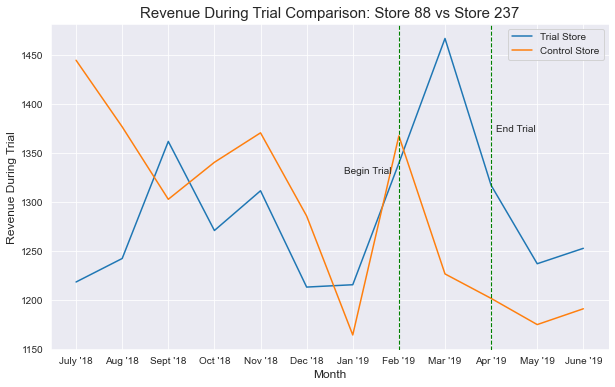

In [208]:
# Visualize Sales during Trial
plot_statistics(percentageDiffSales88, 'trialSales', 'controlSales', 'Revenue During Trial', 88, 237)

# 2(c)(iii) Insights - Store 88 Sales

- Store 88 had a dramatic increase in sales over the control store in 2/3 trial months.
- In March and April, store 88 had 19.6% and 9.6% more sales than store 237.
- In Febuary however, it had 0.02% less sales.

# 2(c)(iv) Significance Testing Store 88 - Sales

Let's see if the difference in the distributions are significant.
We can do this using a t-test.
Our first null hypothesis is that the trial period is the same as the pre-trial period. Let's take the standrd deviation based on the scaled percentage difference in the pre-trial period. 

We will test with a null hypothesis of there being 0 difference between trial and control stores.

In [209]:
# degrees of freedom
"""
Since there are 8 months in the pre-trial period, dof = 7.
"""
dof = 7

# Standard deviation of percentage difference in pre-trial period
stdv88s = percentageDiffSales88[percentageDiffSales88['MONTH_ID'] < 201902]['PercentageDiff'].std()
print(f'Standard Deviation: {stdv88s}')

Standard Deviation: 0.04243209312947482


In [210]:
# Calculate T values for trial months.
percentageDiffSales88['tValue'] = (percentageDiffSales88['PercentageDiff'] - 0) / stdv88s
percentageDiffSales88

,MONTH_ID,trialSales,controlSales,PercentageDiff,MonthYear,tValue
0,201807,1218.20,1444.748231,0.156808,July '18,3.695507
1,201808,1242.20,1376.739250,0.097723,Aug '18,2.303047
2,201809,1361.80,1302.689654,0.045376,Sept '18,1.069370
3,201810,1270.80,1340.495566,0.051992,Oct '18,1.225308
4,201811,1311.40,1370.594487,0.043189,Nov '18,1.017836
5,201812,1213.00,1285.609297,0.056479,Dec '18,1.331033
6,201901,1215.40,1164.067977,0.044097,Jan '19,1.039239
7,201902,1339.60,1367.470032,0.020381,Feb '19,0.480314
8,201903,1467.00,1226.452939,0.196132,Mar '19,4.622264
9,201904,1317.00,1201.457295,0.096169,Apr '19,2.266417


In [211]:
# lineplot the confidence intervals df
ciSales88 = percentageDiffSales88[['MONTH_ID', 'MonthYear', 'trialSales','controlSales', 'tValue']]
ciSales88['95th%ConfidenceInterv'] = ciSales88['controlSales'] * (1+(stdv88s * 2))
ciSales88['5th%ConfidenceInterv'] = ciSales88['controlSales']* (1-(stdv88s * 2))
ciSales88

,MONTH_ID,MonthYear,trialSales,controlSales,tValue,95th%ConfidenceInterv,5th%ConfidenceInterv
0,201807,July '18,1218.20,1444.748231,3.695507,1567.355614,1322.140848
1,201808,Aug '18,1242.20,1376.739250,2.303047,1493.575106,1259.903393
2,201809,Sept '18,1361.80,1302.689654,1.069370,1413.241351,1192.137956
3,201810,Oct '18,1270.80,1340.495566,1.225308,1454.255631,1226.735500
4,201811,Nov '18,1311.40,1370.594487,1.017836,1486.908873,1254.280101
5,201812,Dec '18,1213.00,1285.609297,1.331033,1394.711484,1176.507110
6,201901,Jan '19,1215.40,1164.067977,1.039239,1262.855659,1065.280296
7,201902,Feb '19,1339.60,1367.470032,0.480314,1483.519263,1251.420800
8,201903,Mar '19,1467.00,1226.452939,4.622264,1330.534870,1122.371009
9,201904,Apr '19,1317.00,1201.457295,2.266417,1303.417991,1099.496599


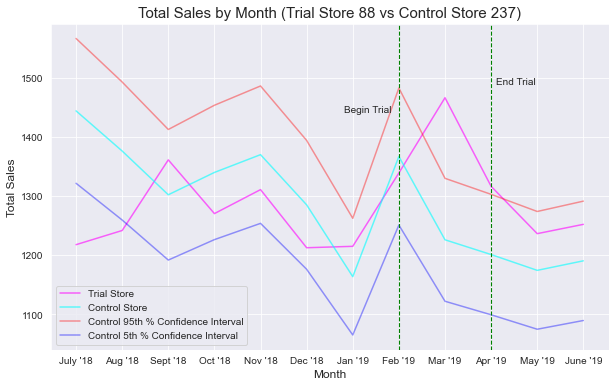

In [212]:
# Plot confidence intervals
plot_confidence_interval(ciSales88, 'Total Sales', 'trialSales', 'controlSales', '95th%ConfidenceInterv', '5th%ConfidenceInterv', 88, 237)

In [213]:
# Find the t-value range corresponding to a 95% confidence interval
stats.t.ppf(0.975, # quantile to check
           dof)    # Degrees of Freedom (number of samples - 1)

2.3646242510102993

Our results show that months March and April lay outside the 5th % and 95th % confidence interval range of the t-distribution. This tells us that the difference in sales in those months are statistically greater than the control store.

We will do the same with customers.

# 2(c)(v) Analysis: Store 88 Customers

In [214]:
# Scale pre-trial control customers to match pre-trial trial store customers
scalingFactorControlCust88 = (measuresOverTime[measuresOverTime['STORE_NBR'] == 88]['nCustomers'].sum())/ (measuresOverTime[measuresOverTime['STORE_NBR'] == 237]['nCustomers'].sum())
print(f'Scaling Factor (cust) for store 88: {scalingFactorControlCust88}')

Scaling Factor (cust) for store 88: 1.0103950103950103


In [215]:
# Apply Scaling Factor
scaledControlCust237 = measuresOverTime[measuresOverTime['STORE_NBR'] == 237]
scaledControlCust237['controlCust'] = scaledControlCust237['nCustomers'] * scalingFactorControlCust88
scaledControlCust237

,STORE_NBR,MONTH_ID,totSales,nCustomers,avgUnitPrice,controlCust
2743,237,201807,1387.2,125,4.446154,126.299376
2744,237,201808,1321.9,132,4.348355,133.372141
2745,237,201809,1250.8,120,4.388772,121.247401
2746,237,201810,1287.1,118,4.484669,119.226611
2747,237,201811,1316.0,125,4.328947,126.299376
2748,237,201812,1234.4,121,4.361837,122.257796
2749,237,201901,1117.7,111,4.349027,112.153846
2750,237,201902,1313.0,119,4.435811,120.237006
2751,237,201903,1177.6,116,4.394030,117.205821
2752,237,201904,1153.6,116,4.403053,117.205821


Now that we have comaprable customer figures, we can calculate the percentage difference between the scaled control customers and the trial store's customers during the trial period.

In [216]:
# Get percentage difference between scaled control customers and trial customers
trialCust88 = measuresOverTime[measuresOverTime['STORE_NBR'] == 88].reset_index(drop = True)
scaledControlCust237 = scaledControlCust237.reset_index(drop = True)
percentageDiffCust88 = pd.concat([trialCust88['MONTH_ID'], trialCust88['nCustomers'], scaledControlCust237['controlCust']], axis = 1)
percentageDiffCust88.columns = ['MONTH_ID', 'trialCust', 'controlCust']
percentageDiffCust88['PercentageDiff'] = (abs(percentageDiffCust88['trialCust'] - percentageDiffCust88['controlCust'])) / percentageDiffCust88['controlCust']
percentageDiffCust88['MonthYear'] = months
percentageDiffCust88

,MONTH_ID,trialCust,controlCust,PercentageDiff,MonthYear
0,201807,124,126.299376,0.018206,July '18
1,201808,125,133.372141,0.062773,Aug '18
2,201809,121,121.247401,0.002040,Sept '18
3,201810,120,119.226611,0.006487,Oct '18
4,201811,123,126.299376,0.026123,Nov '18
5,201812,120,122.257796,0.018468,Dec '18
6,201901,115,112.153846,0.025377,Jan '19
7,201902,122,120.237006,0.014663,Feb '19
8,201903,133,117.205821,0.134756,Mar '19
9,201904,119,117.205821,0.015308,Apr '19


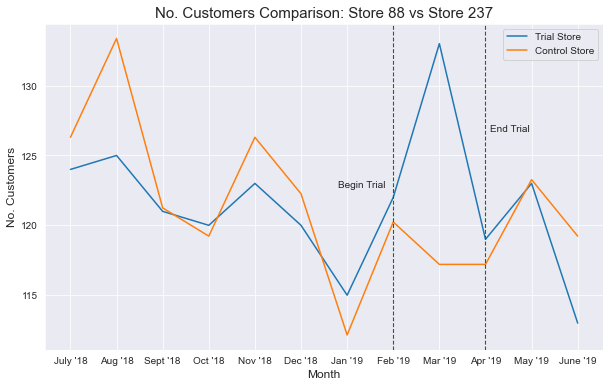

In [217]:
# Plot Visual of performance
plot_statistics(percentageDiffCust88, 'trialCust', 'controlCust', 'No. Customers', 88, 237)

# 2(c)(vi) - Insights - Store 88 Customers

- Store 88 had a dramatic increase in customers throughout March.
- In march, store 88 had 13.5% more customers than store 237.
- Throughout the trial, store 88 maintained a higher number of customers than its control store 237.

# 2(c)(vii) Significance Testing - Customers

Let's see if the difference in the distributions are significant. We can do this using a t-test. Our first null hypothesis is that the trial period is the same as the pre-trial period. Let's take the standrd deviation based on the scaled percentage difference in the pre-trial period.

We will test with a null hypothesis of there being 0 difference between trial and control stores.

In [218]:
# degrees of freedom
"""
Since there are 8 months in the pre-trial period, dof = 7.
"""
dof = 7

# Standard deviation of percentage difference in pre-trial period
stdv88c = percentageDiffCust88[percentageDiffCust88['MONTH_ID'] < 201902]['PercentageDiff'].std()
print(f'Standard Deviation: {stdv88c}')

Standard Deviation: 0.01980096062033321


In [219]:
# Calculate T values for trial months.
percentageDiffCust88['tValue'] = (percentageDiffCust88['PercentageDiff'] - 0) / stdv88c
percentageDiffCust88

,MONTH_ID,trialCust,controlCust,PercentageDiff,MonthYear,tValue
0,201807,124,126.299376,0.018206,July '18,0.919438
1,201808,125,133.372141,0.062773,Aug '18,3.170189
2,201809,121,121.247401,0.002040,Sept '18,0.103049
3,201810,120,119.226611,0.006487,Oct '18,0.327596
4,201811,123,126.299376,0.026123,Nov '18,1.319302
5,201812,120,122.257796,0.018468,Dec '18,0.932657
6,201901,115,112.153846,0.025377,Jan '19,1.281616
7,201902,122,120.237006,0.014663,Feb '19,0.740502
8,201903,133,117.205821,0.134756,Mar '19,6.805525
9,201904,119,117.205821,0.015308,Apr '19,0.773090


Our t-value will tell allow us to test with a null hypothesis that there is zero difference between trial and control stores.

In [220]:
ciCust88 = percentageDiffCust88[['MONTH_ID', 'MonthYear', 'trialCust','controlCust', 'tValue']]
ciCust88['95th%ConfidenceInterv'] = ciCust88['controlCust'] * (1+(stdv88c * 2))
ciCust88['5th%ConfidenceInterv'] = ciCust88['controlCust']* (1-(stdv88c * 2))
ciCust88

,MONTH_ID,MonthYear,trialCust,controlCust,tValue,95th%ConfidenceInterv,5th%ConfidenceInterv
0,201807,July '18,124,126.299376,0.919438,131.301074,121.297678
1,201808,Aug '18,125,133.372141,3.170189,138.653934,128.090348
2,201809,Sept '18,121,121.247401,0.103049,126.049031,116.445771
3,201810,Oct '18,120,119.226611,0.327596,123.948214,114.505008
4,201811,Nov '18,123,126.299376,1.319302,131.301074,121.297678
5,201812,Dec '18,120,122.257796,0.932657,127.099440,117.416153
6,201901,Jan '19,115,112.153846,1.281616,116.595354,107.712338
7,201902,Feb '19,122,120.237006,0.740502,124.998623,115.475390
8,201903,Mar '19,133,117.205821,6.805525,121.847397,112.564246
9,201904,Apr '19,119,117.205821,0.773090,121.847397,112.564246


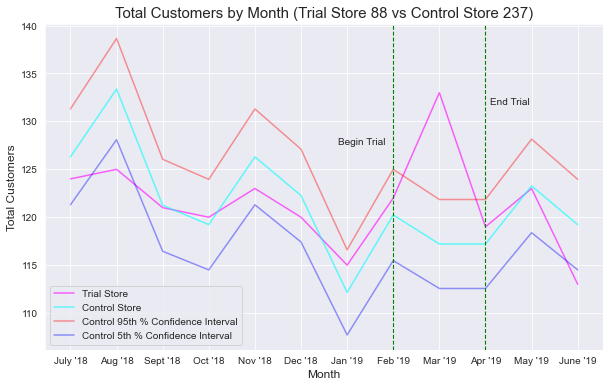

In [221]:
# Plot confidence intervals
plot_confidence_interval(ciCust88, 'Total Customers', 'trialCust', 'controlCust', '95th%ConfidenceInterv', '5th%ConfidenceInterv', 88, 237)

In [222]:
# Find the t-value range corresponding to a 95% confidence interval
stats.t.ppf(0.975, # quantile to check
           dof)    # Degrees of Freedom (number of samples - 1)

2.3646242510102993

Our results show that the t-values for March lay outside the 5% to 95% confidence interval value of the t-distribution. This tells us that the changes in customers for store 88 are statistically significant in March only.

# 3 - Conclusion

For our trial stores 77, 86 and 88, we found control stores 233, 155 and 237 respectively. 
The results for trail store 77 show a significant increase in both sales and customers in months March and April.
The same can be said for store 88.
However, store 86 saw only significant increase in 1 of the 3 months (March). We can check with the client if the implementation of the trial is somehow different in this store, or if there were any specials present in this store during the time which resulted in lower sales, as suggested by the increase in customers but lower sales.

Now that we have finished our analysis, we can prepare our presentation to the Category Manager.